# 学習
- パラメータチューニング

In [1]:
# パラメータ設定

In [2]:
TARGET_DATE = '20210101'

In [34]:
TARGET_DATE = str(TARGET_DATE)

In [3]:
# ライブラリ読み込み

In [4]:
import pandas as pd
import numpy as np
import argparse
import shap
import optuna
import pickle
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [5]:
# dataframe設定調整

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [7]:
# データ読み込み

In [8]:
train = pd.read_pickle(f'../../data/trial/feature_{TARGET_DATE}.pkl')

In [9]:
target = 'TARGET'

In [10]:
X = train.drop(columns=target)

In [11]:
y = train[target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0,
                                                   stratify=y)

In [13]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [14]:
categorical_features = [
# 'prefecture_code'
]

In [15]:
lgb_train = lgb.Dataset(X_train, y_train,
                       categorical_feature=categorical_features,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

In [16]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(
        param,                                   # 上記で設定したパラメータ
        lgb_train,                                # 使用するデータセット
        num_boost_round=1000,                     # 学習の回数
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        categorical_feature=categorical_features, # カテゴリー変数を設定
        early_stopping_rounds=50,                 # アーリーストッピング
        verbose_eval=10)                          # 学習の経過の表示(10回毎)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    
    # metrics AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    score = metrics.auc(fpr, tpr)

    # metrics F1
#     score = f1_score(y_train, y_pred)

    # MLFlow
#     with mlflow.start_run() as run:
#         mlflow.log_params(param)
#         mlflow.log_metrics({'accuracy': accuracy})
#         mlflow.lightgbm.log_model(gbm, 'model', args.conda_env)
#     print('Model logged in run {}'.format(run.info.run_uuid))
    return score

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2021-01-09 09:01:06,021] A new study created in memory with name: no-name-42eccef6-0497-4ddd-aafe-541cba47ab24


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.784057	valid's auc: 0.733927
[20]	train's auc: 0.806329	valid's auc: 0.738536
[30]	train's auc: 0.826598	valid's auc: 0.741209
[40]	train's auc: 0.843837	valid's auc: 0.741997
[50]	train's auc: 0.860957	valid's auc: 0.743253
[60]	train's auc: 0.876499	valid's auc: 0.742987
[70]	train's auc: 0.889832	valid's auc: 0.742821
[80]	train's auc: 0.901631	valid's auc: 0.742445
[90]	train's auc: 0.911375	valid's auc: 0.741881
[100]	train's auc: 0.920728	valid's auc: 0.740603
Early stopping, best iteration is:
[52]	train's auc: 0.864459	valid's auc: 0.743462


[I 2021-01-09 09:01:11,134] Trial 0 finished with value: 0.8644590894249773 and parameters: {'lambda_l1': 0.0001090282234488675, 'lambda_l2': 1.1897821140675588, 'num_leaves': 194, 'feature_fraction': 0.7322974727663317, 'bagging_fraction': 0.8417275993906015, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 0 with value: 0.8644590894249773.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.75051	valid's auc: 0.730651
[20]	train's auc: 0.763568	valid's auc: 0.740047
[30]	train's auc: 0.771286	valid's auc: 0.742254
[40]	train's auc: 0.78005	valid's auc: 0.743352
[50]	train's auc: 0.787763	valid's auc: 0.744073
[60]	train's auc: 0.795334	valid's auc: 0.744645
[70]	train's auc: 0.802848	valid's auc: 0.744206
[80]	train's auc: 0.809412	valid's auc: 0.744287
[90]	train's auc: 0.816006	valid's auc: 0.744399
[100]	train's auc: 0.822264	valid's auc: 0.743987
Early stopping, best iteration is:
[54]	train's auc: 0.790773	valid's auc: 0.744727


[I 2021-01-09 09:01:13,828] Trial 1 finished with value: 0.790773108708702 and parameters: {'lambda_l1': 0.3798653308415664, 'lambda_l2': 0.00029539243456053654, 'num_leaves': 55, 'feature_fraction': 0.4899103656748761, 'bagging_fraction': 0.5393826975746222, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 0 with value: 0.8644590894249773.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.750991	valid's auc: 0.735385
[20]	train's auc: 0.76227	valid's auc: 0.739281
[30]	train's auc: 0.772745	valid's auc: 0.742773
[40]	train's auc: 0.781321	valid's auc: 0.746012
[50]	train's auc: 0.789395	valid's auc: 0.747558
[60]	train's auc: 0.796826	valid's auc: 0.748519
[70]	train's auc: 0.803968	valid's auc: 0.749072
[80]	train's auc: 0.809814	valid's auc: 0.748953
[90]	train's auc: 0.815924	valid's auc: 0.748378
[100]	train's auc: 0.822002	valid's auc: 0.748256
[110]	train's auc: 0.82793	valid's auc: 0.748013
[120]	train's auc: 0.833341	valid's auc: 0.748223
Early stopping, best iteration is:
[71]	train's auc: 0.804429	valid's auc: 0.749221


[I 2021-01-09 09:01:17,905] Trial 2 finished with value: 0.8044287568784576 and parameters: {'lambda_l1': 4.166656665269796e-06, 'lambda_l2': 0.5783765562675204, 'num_leaves': 51, 'feature_fraction': 0.7699619482496199, 'bagging_fraction': 0.8595716022239032, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 0 with value: 0.8644590894249773.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.78361	valid's auc: 0.73393
[20]	train's auc: 0.807353	valid's auc: 0.735777
[30]	train's auc: 0.829258	valid's auc: 0.737462
[40]	train's auc: 0.849097	valid's auc: 0.737551
[50]	train's auc: 0.866139	valid's auc: 0.738852
[60]	train's auc: 0.882861	valid's auc: 0.738266
[70]	train's auc: 0.896878	valid's auc: 0.736859
[80]	train's auc: 0.908666	valid's auc: 0.736702
[90]	train's auc: 0.91874	valid's auc: 0.735193
[100]	train's auc: 0.927838	valid's auc: 0.733901
Early stopping, best iteration is:
[57]	train's auc: 0.877857	valid's auc: 0.739301


[I 2021-01-09 09:01:22,352] Trial 3 finished with value: 0.8778566150884992 and parameters: {'lambda_l1': 0.00027413572104711113, 'lambda_l2': 0.30967661220963616, 'num_leaves': 218, 'feature_fraction': 0.7506296141507798, 'bagging_fraction': 0.6278790355923303, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.760485	valid's auc: 0.730527
[20]	train's auc: 0.779835	valid's auc: 0.736148
[30]	train's auc: 0.799607	valid's auc: 0.738981
[40]	train's auc: 0.816564	valid's auc: 0.740928
[50]	train's auc: 0.831175	valid's auc: 0.740655
[60]	train's auc: 0.844696	valid's auc: 0.739379
[70]	train's auc: 0.856632	valid's auc: 0.739368
[80]	train's auc: 0.867434	valid's auc: 0.738508
[90]	train's auc: 0.876289	valid's auc: 0.738022
Early stopping, best iteration is:
[44]	train's auc: 0.822973	valid's auc: 0.741049


[I 2021-01-09 09:01:24,996] Trial 4 finished with value: 0.8229732412769211 and parameters: {'lambda_l1': 0.000733803816415297, 'lambda_l2': 0.09198767717776889, 'num_leaves': 111, 'feature_fraction': 0.8355304051833657, 'bagging_fraction': 0.47944859146489244, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.772214	valid's auc: 0.737583
[20]	train's auc: 0.788079	valid's auc: 0.741401
[30]	train's auc: 0.802588	valid's auc: 0.744377
[40]	train's auc: 0.815711	valid's auc: 0.74504
[50]	train's auc: 0.829278	valid's auc: 0.745953
[60]	train's auc: 0.842083	valid's auc: 0.745392
[70]	train's auc: 0.85249	valid's auc: 0.746151
[80]	train's auc: 0.862873	valid's auc: 0.745448
[90]	train's auc: 0.872508	valid's auc: 0.744519
[100]	train's auc: 0.880971	valid's auc: 0.743753
Early stopping, best iteration is:
[53]	train's auc: 0.83263	valid's auc: 0.746293


[I 2021-01-09 09:01:28,499] Trial 5 finished with value: 0.8326295361748861 and parameters: {'lambda_l1': 0.16534750390962738, 'lambda_l2': 3.1003528777434166e-05, 'num_leaves': 123, 'feature_fraction': 0.5978020882043732, 'bagging_fraction': 0.881183119770132, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.781029	valid's auc: 0.737746
[20]	train's auc: 0.799378	valid's auc: 0.741842
[30]	train's auc: 0.817649	valid's auc: 0.743568
[40]	train's auc: 0.832678	valid's auc: 0.743442
[50]	train's auc: 0.847855	valid's auc: 0.744798
[60]	train's auc: 0.861495	valid's auc: 0.74448
[70]	train's auc: 0.873749	valid's auc: 0.744236
[80]	train's auc: 0.884922	valid's auc: 0.743725
[90]	train's auc: 0.895037	valid's auc: 0.7437
Early stopping, best iteration is:
[48]	train's auc: 0.844931	valid's auc: 0.745189


[I 2021-01-09 09:01:32,198] Trial 6 finished with value: 0.8449306370667145 and parameters: {'lambda_l1': 0.001347469354432729, 'lambda_l2': 1.9741452984812773, 'num_leaves': 172, 'feature_fraction': 0.6963490483194525, 'bagging_fraction': 0.8661986898100953, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.764744	valid's auc: 0.735428
[20]	train's auc: 0.7831	valid's auc: 0.740031
[30]	train's auc: 0.801993	valid's auc: 0.743621
[40]	train's auc: 0.817422	valid's auc: 0.744993
[50]	train's auc: 0.831776	valid's auc: 0.746066
[60]	train's auc: 0.844537	valid's auc: 0.746472
[70]	train's auc: 0.855681	valid's auc: 0.746665
[80]	train's auc: 0.865626	valid's auc: 0.746281
[90]	train's auc: 0.874532	valid's auc: 0.745449
[100]	train's auc: 0.883771	valid's auc: 0.744864
[110]	train's auc: 0.891251	valid's auc: 0.74432
[120]	train's auc: 0.898612	valid's auc: 0.743124
Early stopping, best iteration is:
[71]	train's auc: 0.856818	valid's auc: 0.746734


[I 2021-01-09 09:01:36,172] Trial 7 finished with value: 0.8568180317935028 and parameters: {'lambda_l1': 1.0478968712244278e-07, 'lambda_l2': 0.0015494075770551873, 'num_leaves': 119, 'feature_fraction': 0.870459403126382, 'bagging_fraction': 0.9140213825070267, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.744835	valid's auc: 0.733171
[20]	train's auc: 0.752609	valid's auc: 0.738456
[30]	train's auc: 0.75734	valid's auc: 0.740802
[40]	train's auc: 0.761362	valid's auc: 0.743167
[50]	train's auc: 0.765404	valid's auc: 0.744861
[60]	train's auc: 0.769528	valid's auc: 0.746347
[70]	train's auc: 0.773328	valid's auc: 0.74764
[80]	train's auc: 0.776934	valid's auc: 0.747659
[90]	train's auc: 0.780289	valid's auc: 0.747772
[100]	train's auc: 0.783144	valid's auc: 0.747667
[110]	train's auc: 0.785728	valid's auc: 0.747626
[120]	train's auc: 0.788688	valid's auc: 0.747332
[130]	train's auc: 0.791857	valid's auc: 0.74743
[140]	train's auc: 0.794525	valid's auc: 0.747285
[150]	train's auc: 0.796748	valid's auc: 0.74695
Early stopping, best iteration is:
[105]	train's auc: 0.784325	valid's auc: 0.747918


[I 2021-01-09 09:01:39,487] Trial 8 finished with value: 0.7843251409179617 and parameters: {'lambda_l1': 3.589733397716107e-08, 'lambda_l2': 3.976886866752597e-07, 'num_leaves': 24, 'feature_fraction': 0.58878083517764, 'bagging_fraction': 0.4527984546793688, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 3 with value: 0.8778566150884992.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.775358	valid's auc: 0.729494
[20]	train's auc: 0.803156	valid's auc: 0.735686
[30]	train's auc: 0.825595	valid's auc: 0.736673
[40]	train's auc: 0.846412	valid's auc: 0.73818
[50]	train's auc: 0.863668	valid's auc: 0.737149
[60]	train's auc: 0.878613	valid's auc: 0.737439
[70]	train's auc: 0.892269	valid's auc: 0.735434
[80]	train's auc: 0.904203	valid's auc: 0.734966
[90]	train's auc: 0.915687	valid's auc: 0.733751
Early stopping, best iteration is:
[40]	train's auc: 0.846412	valid's auc: 0.73818


[I 2021-01-09 09:01:42,690] Trial 9 finished with value: 0.846412411179011 and parameters: {'lambda_l1': 5.620983809886155e-06, 'lambda_l2': 0.0030695111276306843, 'num_leaves': 193, 'feature_fraction': 0.8852129407429024, 'bagging_fraction': 0.6362529368295452, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 3 with value: 0.8778566150884992.


Number of finished trials: 10
Best trial:
  Value: 0.8778566150884992
  Params: 
    lambda_l1: 0.00027413572104711113
    lambda_l2: 0.30967661220963616
    num_leaves: 218
    feature_fraction: 0.7506296141507798
    bagging_fraction: 0.6278790355923303
    bagging_freq: 7
    min_child_samples: 82


In [18]:
# 二値分類
params = {
            'boosting_type': 'gbdt',        # 勾配ブースティング
            'objective': 'binary',      # 目的関数：多値分類、マルチクラス分類
            'metric': 'auc',      # 分類モデルの性能を測る指標
         }

In [19]:
params = dict(params, **study.best_params)

In [20]:
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=50,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15390, number of negative: 175016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3201
[LightGBM] [Info] Number of data points in the train set: 190406, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080827 -> initscore=-2.431159
[LightGBM] [Info] Start training from score -2.431159
Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.78361	valid's auc: 0.73393
[20]	train's auc: 0.807353	valid's auc: 0.735777
[30]	train's auc: 0.829258	valid's auc: 0.737462
[40]	train's auc: 0.849097	valid's auc: 0.737551
[50]	train's auc: 0.866139	valid's auc: 0.738852
[60]	train's auc: 0.882861	valid's auc: 0.738266
[70]

0.8778566150884992


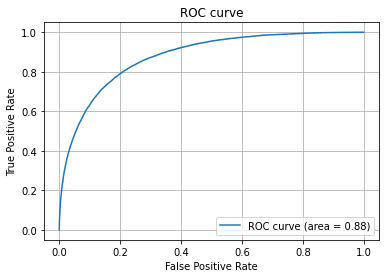

In [21]:
# # 訓練データで予測
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.7473855315544758


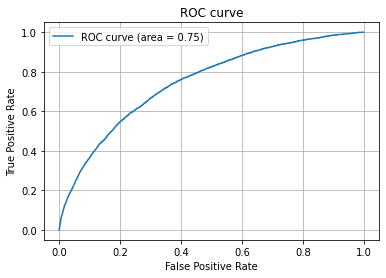

In [22]:
# # テストデータで予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [23]:
pickle.dump(model, open(f'../../data/trial/model_{TARGET_DATE}.pkl', 'wb'))